## Optimizacion Angulo usando Machine Learning

## 1.  Crear la BD

###  Importar las librerias necesarias

In [39]:
# import dependencias
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from neuralprophet import NeuralProphet
import random
from datetime import datetime
import seaborn as sns

###  Nota: Sobre la  Metodología para determinar los ángulos de inclinación óptimos

Se supone que todos los paneles miran hacia el norte en el hemisferio sur (ángulo de acimut de 0°),

Datos del panel:
latitud:-12.0460686,lonitud: -76.9744548
Altitud : 249 m
Dimensiones del panel :60 alto x 40 ancho 

###  ¿ Cómo se obtienen los angulos optimos del panel?

Se obtienen de manera experimental, colocando varios paneles (o un panel) en diferentes grado de inclinacion por un tiempo
definido (varios meses)

El ángulo de inclinación óptimo en cada ubicación se encuentra calculando la salida del panel con diferente inclinación
ángulos hasta que se encuentre el ángulo de inclinación que da la salida máxima.

A continuación se muestran los datos recabados para construir la Base de datos crudos

-Datos del módulo fotovoltaico:
Angulo

-Datos meteorológicos 
Temperatura (°C)
Precipitación (mm/Hora)
Humedad (%)
Direccion Del Viento (°)
Velocidad Del Viento (m/s) 

-Datos para Crear las series temporales Angulo vs tiempo 
Año
Mes
Hora
Minutos


### Datos meteorológicos

La Estación mas cercana a al punto de estudio es la Estación : CERES cuyos metadatos se presentan aqui
Departamento : LIMA	
Provincia : LIMA	
Distrito : ATE	
Latitud : 12°1'43.2'' S	
Longitud : 76°55'37.6'' W	
Altitud : 339 msnm.
Tipo : Automatica - Meteorológica	
Codigo : 112278

El periodo de estudio fue desde enero hasta Marzo 2023.

Se descargaron del portal web https://www.senamhi.gob.pe/?&p=estaciones los ficheros .csv con los datos diarios.

Fuente: SENAMHI / DRD
* Datos sin control de calidad.
* El uso de estos datos será de entera responsabilidad del usuario

Se utilizó la libreria pandas para leer por separado cada fichero .csv, de cada mes y se concatenaron en solo dataframe tal como sigue

In [40]:
data_ene  = pd.read_csv('01.csv',index_col=0, sep=';', encoding='latin-1')
data_feb  = pd.read_csv('02.csv',index_col=0, sep=';', encoding='latin-1')
data_marz = pd.read_csv('03.csv',index_col=0, sep=';', encoding='latin-1')

# se concatenan los dataframe enhttps://www.senamhi.gob.pe/?&p=estaciones uno solo
df_raw_daily=pd.concat([data_ene,data_feb,data_marz])


### Acoplamiento de datos meteorológicos con angulos optimos

Estos datos se unieron con el angulo optimo para formar un dataframe crudo que fue guardado en formato excel.

A continuación se realiza la lectura de la base de datos cruda.

In [41]:
df_raw_daily=pd.read_excel('datos_crudos2.xlsx')
# veamos la comunas del datafram original
df_raw_daily.columns


Index(['AÑO / MES / DÍA ', 'HORA ', 'TEMPERATURA (°C) ',
       'PRECIPITACIÓN (mm/hora) ', 'HUMEDAD (%) ', 'DIRECCION DEL VIENTO (°) ',
       'VELOCIDAD DEL VIENTO (m/s) ', 'Unnamed: 7', 'ang. opt'],
      dtype='object')

In [42]:
df_raw_daily.head(8)

,AÑO / MES / DÍA,HORA,TEMPERATURA (°C),PRECIPITACIÓN (mm/hora),HUMEDAD (%),DIRECCION DEL VIENTO (°),VELOCIDAD DEL VIENTO (m/s),Unnamed: 7,ang. opt
0,25/01/2023,16:00,25.2,0.0,50.88,168.9,1.9,NaN,26.0
1,25/01/2023,17:00,23.6,18.7,61.07,204.9,2.1,NaN,31.0
2,25/01/2023,18:00,21.9,0.1,69.39,207.0,1.6,NaN,31.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25/01/2023,19:00,21.5,0.1,72.06,212.5,1.1,NaN,31.0
5,25/01/2023,20:00,21.1,0.0,74.33,213.0,1.2,NaN,31.0
6,25/01/2023,21:00,21.2,0.0,72.60,220.2,0.7,NaN,31.0
7,25/01/2023,22:00,20.6,0.0,78.52,198.9,1.3,NaN,31.0


Vemos que hay columnas sin datos , que luego serán depurados

### Gráficas de datos crudos

Graficamos la serie temporal de temperatura  y vemos que nos da error

In [43]:
#plt.plot(df_raw_daily['AÑO / MES / DÍA '],df_raw_daily['TEMPERATURA (°C) '])

## 2. Creacion del Datasets

### Analisis exporatorio de Datos EDA


Consiste en :
- Eliminar columna sin datos
- Eliminar filas vacias
- Resetear los indices de filas
- Conversión de Fechas y horas en una sola columna tipo datetime
- Eliminar duplicados 

- Extraccion de atributos y estudios de correlacion
- Obtención de atributos de la serie temporal


### Eliminación de columnas sin datos

In [44]:
df_raw_daily.drop(['Unnamed: 7'], axis=1,inplace=True)
df_raw_daily.head(8)

,AÑO / MES / DÍA,HORA,TEMPERATURA (°C),PRECIPITACIÓN (mm/hora),HUMEDAD (%),DIRECCION DEL VIENTO (°),VELOCIDAD DEL VIENTO (m/s),ang. opt
0,25/01/2023,16:00,25.2,0.0,50.88,168.9,1.9,26.0
1,25/01/2023,17:00,23.6,18.7,61.07,204.9,2.1,31.0
2,25/01/2023,18:00,21.9,0.1,69.39,207.0,1.6,31.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25/01/2023,19:00,21.5,0.1,72.06,212.5,1.1,31.0
5,25/01/2023,20:00,21.1,0.0,74.33,213.0,1.2,31.0
6,25/01/2023,21:00,21.2,0.0,72.60,220.2,0.7,31.0
7,25/01/2023,22:00,20.6,0.0,78.52,198.9,1.3,31.0


### Eliminación filas vacias

In [45]:
print('La cantidad de registros antes era:', len( df_raw_daily))
df_raw_daily = df_raw_daily.dropna(how='all')

print('La cantidad de registros despues es:', len( df_raw_daily))
df_raw_daily.head(8)


La cantidad de registros antes era: 1505
La cantidad de registros despues es: 1502


,AÑO / MES / DÍA,HORA,TEMPERATURA (°C),PRECIPITACIÓN (mm/hora),HUMEDAD (%),DIRECCION DEL VIENTO (°),VELOCIDAD DEL VIENTO (m/s),ang. opt
0,25/01/2023,16:00,25.2,0.0,50.88,168.9,1.9,26.0
1,25/01/2023,17:00,23.6,18.7,61.07,204.9,2.1,31.0
2,25/01/2023,18:00,21.9,0.1,69.39,207.0,1.6,31.0
4,25/01/2023,19:00,21.5,0.1,72.06,212.5,1.1,31.0
5,25/01/2023,20:00,21.1,0.0,74.33,213.0,1.2,31.0
6,25/01/2023,21:00,21.2,0.0,72.60,220.2,0.7,31.0
7,25/01/2023,22:00,20.6,0.0,78.52,198.9,1.3,31.0
8,25/01/2023,23:00,20.0,0.0,82.00,184.5,0.8,31.0


### Volvemos ha intentar las Gráficas de datos crudos

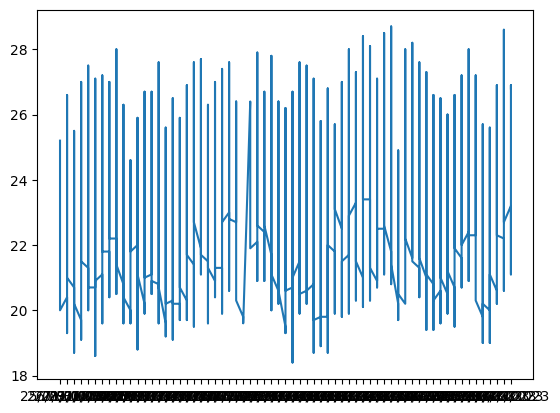

In [46]:
plt.plot(df_raw_daily['AÑO / MES / DÍA '],df_raw_daily['TEMPERATURA (°C) '])

### Resetear indices de fila

In [47]:
df_raw_daily = df_raw_daily.reset_index(drop=True)
df_raw_daily.head(8)


,AÑO / MES / DÍA,HORA,TEMPERATURA (°C),PRECIPITACIÓN (mm/hora),HUMEDAD (%),DIRECCION DEL VIENTO (°),VELOCIDAD DEL VIENTO (m/s),ang. opt
0,25/01/2023,16:00,25.2,0.0,50.88,168.9,1.9,26.0
1,25/01/2023,17:00,23.6,18.7,61.07,204.9,2.1,31.0
2,25/01/2023,18:00,21.9,0.1,69.39,207.0,1.6,31.0
3,25/01/2023,19:00,21.5,0.1,72.06,212.5,1.1,31.0
4,25/01/2023,20:00,21.1,0.0,74.33,213.0,1.2,31.0
5,25/01/2023,21:00,21.2,0.0,72.60,220.2,0.7,31.0
6,25/01/2023,22:00,20.6,0.0,78.52,198.9,1.3,31.0
7,25/01/2023,23:00,20.0,0.0,82.00,184.5,0.8,31.0


### Conversión de Fechas y horas en una sola columna tipo datetime (se crea unja nueva columna llamada 'ds')

In [48]:
df_raw_daily['ds']=[datetime.strptime(df_raw_daily['AÑO / MES / DÍA '][i]+' ' + df_raw_daily['HORA ' ][i],'%d/%m/%Y %H:%M' ) for i in range(len(df_raw_daily)) ]
df_raw_daily.head(8)

,AÑO / MES / DÍA,HORA,TEMPERATURA (°C),PRECIPITACIÓN (mm/hora),HUMEDAD (%),DIRECCION DEL VIENTO (°),VELOCIDAD DEL VIENTO (m/s),ang. opt,ds
0,25/01/2023,16:00,25.2,0.0,50.88,168.9,1.9,26.0,2023-01-25 16:00:00
1,25/01/2023,17:00,23.6,18.7,61.07,204.9,2.1,31.0,2023-01-25 17:00:00
2,25/01/2023,18:00,21.9,0.1,69.39,207.0,1.6,31.0,2023-01-25 18:00:00
3,25/01/2023,19:00,21.5,0.1,72.06,212.5,1.1,31.0,2023-01-25 19:00:00
4,25/01/2023,20:00,21.1,0.0,74.33,213.0,1.2,31.0,2023-01-25 20:00:00
5,25/01/2023,21:00,21.2,0.0,72.60,220.2,0.7,31.0,2023-01-25 21:00:00
6,25/01/2023,22:00,20.6,0.0,78.52,198.9,1.3,31.0,2023-01-25 22:00:00
7,25/01/2023,23:00,20.0,0.0,82.00,184.5,0.8,31.0,2023-01-25 23:00:00


### Eliminar datos duplicados

In [49]:
print('La cantidad de registros antes era:', len( df_raw_daily))
duplicados=df_raw_daily[df_raw_daily['ds'].duplicated()]
duplicados.head(4)
df_raw_daily.drop_duplicates(inplace=True)

print('La cantidad de registros despues es:', len( df_raw_daily))


La cantidad de registros antes era: 1502
La cantidad de registros despues es: 1498


### Nuevas Gráficas de datos crudos

Graficamos la serie temporal de temperatura

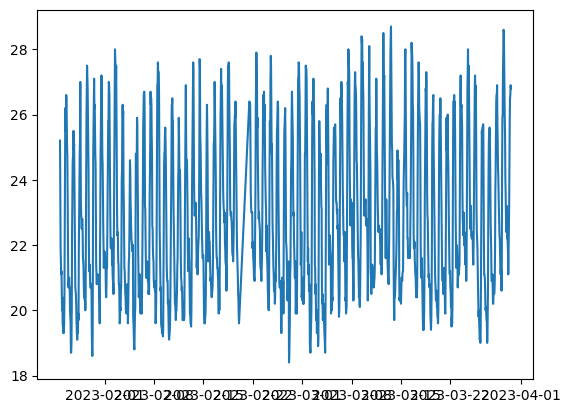

In [50]:
plt.plot(df_raw_daily['ds'],df_raw_daily['TEMPERATURA (°C) '])

Graficamos la serie temporal de Humedad

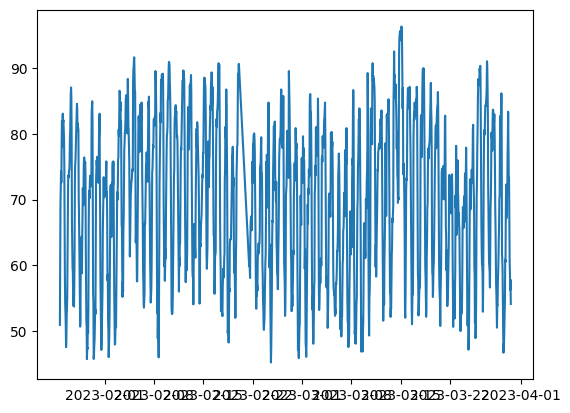

In [51]:
plt.plot(df_raw_daily['ds'],df_raw_daily['HUMEDAD (%) '])

### Extracción de atributos para la Red Neuronal

Se intentará construir un correlograma de nuestro datasets.

Para determinar la importancia de cada uno de los atributos de red contenidos en el conjunto de datos

Ahora se debe calcular la correlacion para todas las variables del Datasets

Veamos como es la Matriz de correlación. Esta matriz muestra la correlación entre dos o más variables del conjunto de datos a través de tabulaciones o estadísticas. 




In [52]:
df_corr=df_raw_daily.corr()
df_corr

,TEMPERATURA (°C),PRECIPITACIÓN (mm/hora),HUMEDAD (%),DIRECCION DEL VIENTO (°),VELOCIDAD DEL VIENTO (m/s),ang. opt
TEMPERATURA (°C),1.000000,0.049651,-0.918746,0.342686,0.785539,-0.284485
PRECIPITACIÓN (mm/hora),0.049651,1.000000,-0.048594,0.020867,0.103232,0.022246
HUMEDAD (%),-0.918746,-0.048594,1.000000,-0.329008,-0.734932,0.213025
DIRECCION DEL VIENTO (°),0.342686,0.020867,-0.329008,1.000000,0.551359,0.040982
VELOCIDAD DEL VIENTO (m/s),0.785539,0.103232,-0.734932,0.551359,1.000000,-0.105632
ang. opt,-0.284485,0.022246,0.213025,0.040982,-0.105632,1.000000


In [53]:
# Ahora se debe encontrar la correlación específica de todas las variables del conjunto de 
# datos respecto a la variable objetivo “ang. opt.”.
correlaciones_ordenadas = df_raw_daily[df_raw_daily.columns[1:]].corr()['ang. opt'][:].sort_values(ascending=False)
print(correlaciones_ordenadas)

ang. opt                       1.000000
HUMEDAD (%)                    0.213025
DIRECCION DEL VIENTO (°)       0.040982
PRECIPITACIÓN (mm/hora)        0.022246
VELOCIDAD DEL VIENTO (m/s)    -0.105632
TEMPERATURA (°C)              -0.284485
Name: ang. opt, dtype: float64


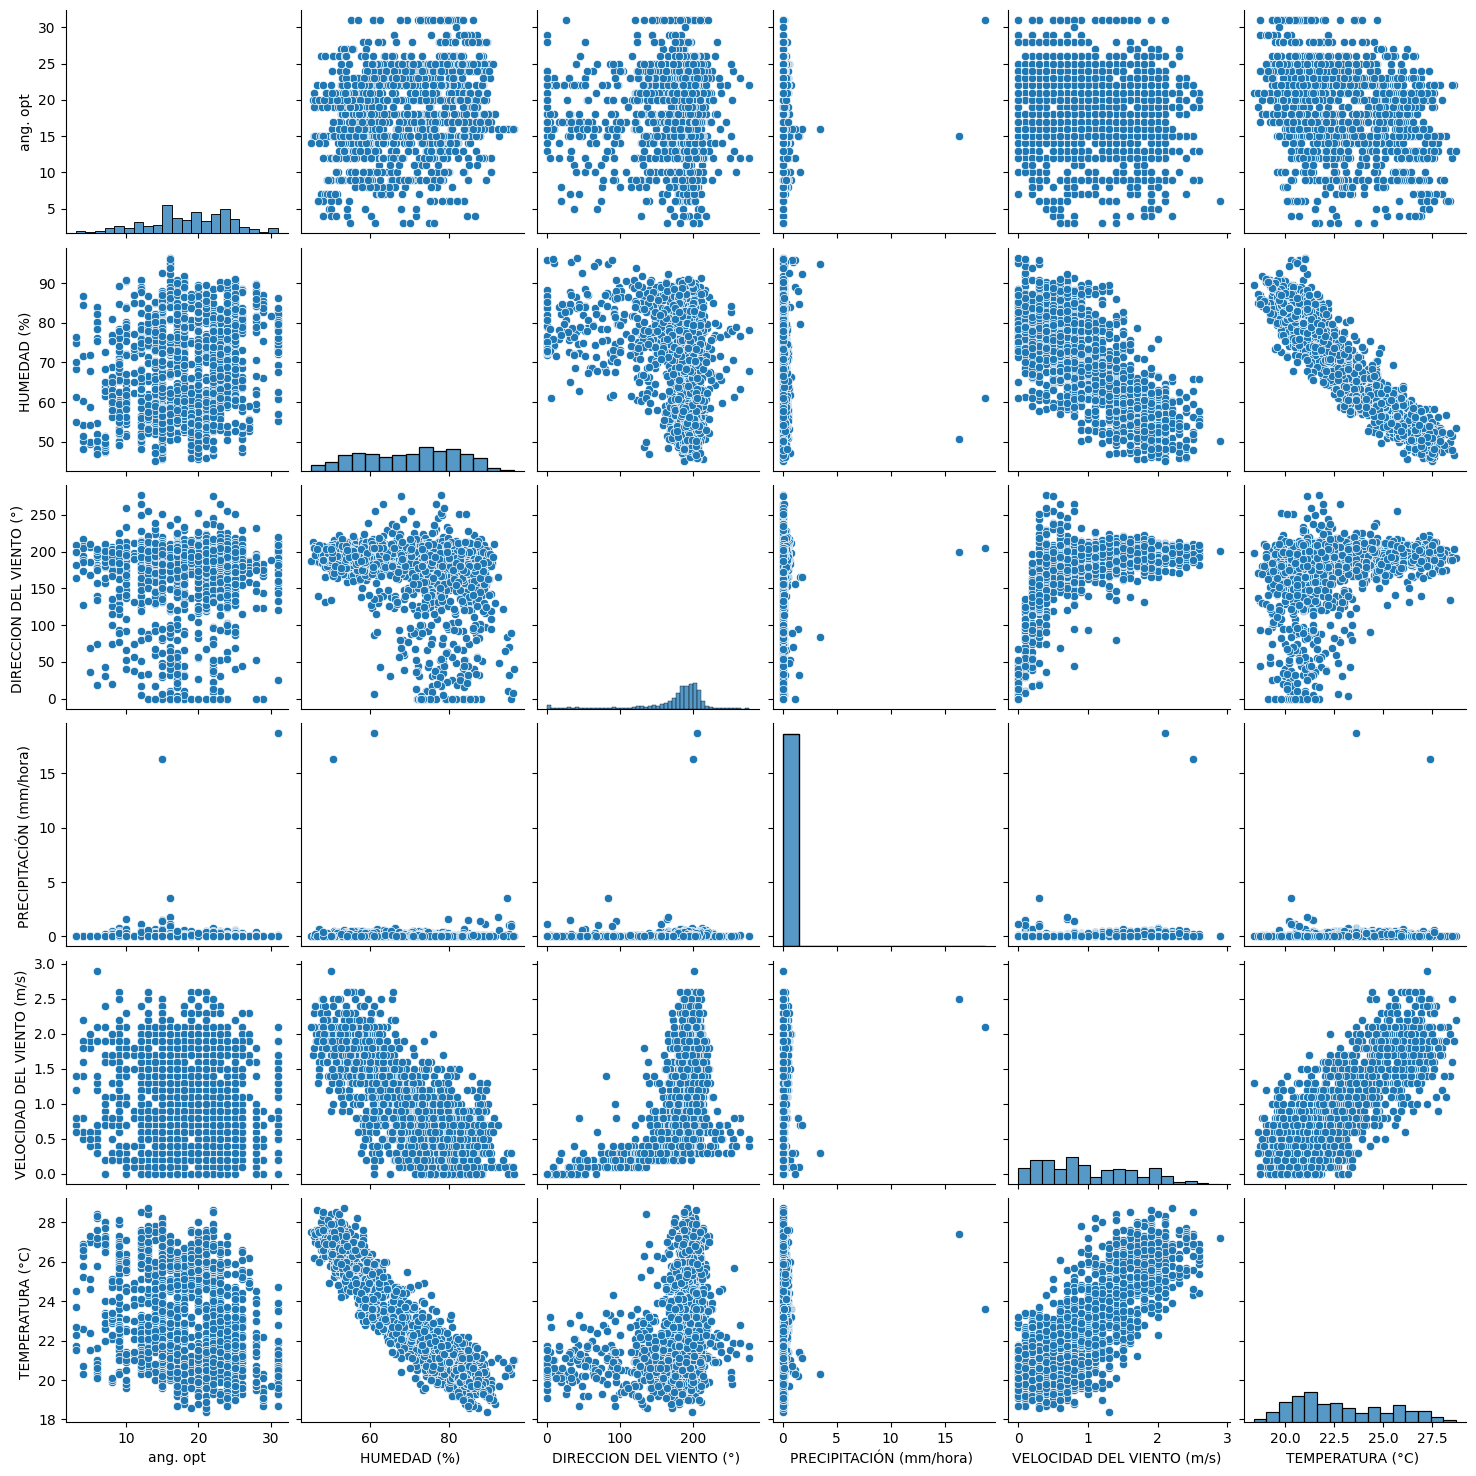

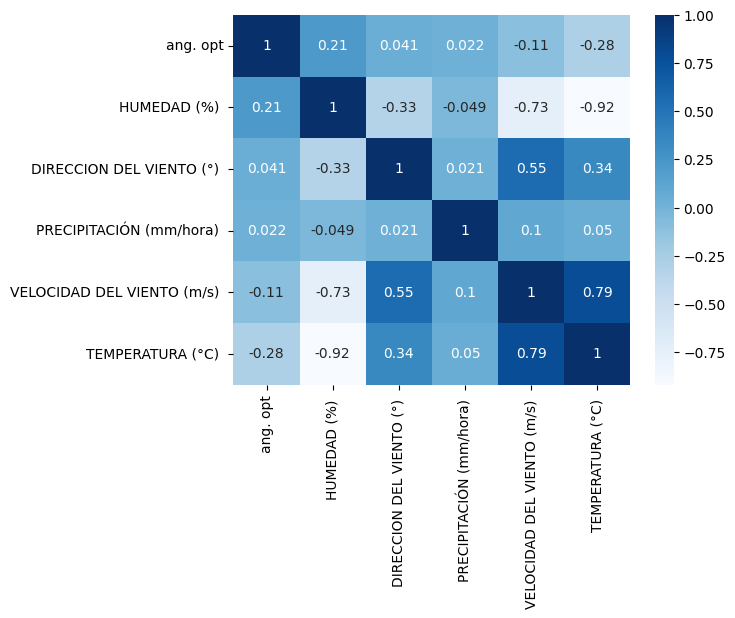

In [54]:
sns.pairplot(data = df_raw_daily, vars=list(correlaciones_ordenadas.index))
plt.show()

sns.heatmap(df_raw_daily[list(correlaciones_ordenadas.index)].corr(), annot=True, cmap = 'Blues')
plt.show()



En la figura anterior se muestra el mapa de calor de correlación entre las  variables y el angulo optimo.

Se obtuvieron correlaciones muy bajas por lo tanto se procede a descartar el uso
de todos los atributos, y se tratara el datasets como una serie temporal, como entrada
a la red neuronal.

### Obtención de atributos de la serie temporal

In [55]:
# vamos a asignar la etiqueta a el angulo optimo
df_raw_daily.rename(columns={"ang. opt": "y"}, inplace=True)
df_raw_daily.columns

Index(['AÑO / MES / DÍA ', 'HORA ', 'TEMPERATURA (°C) ',
       'PRECIPITACIÓN (mm/hora) ', 'HUMEDAD (%) ', 'DIRECCION DEL VIENTO (°) ',
       'VELOCIDAD DEL VIENTO (m/s) ', 'y', 'ds'],
      dtype='object')

In [56]:
# vamops a eliminar las columnas sobrantes pàra dejar dos nada mas 
df_raw_daily.drop(['AÑO / MES / DÍA ','HORA ', 'TEMPERATURA (°C) ','PRECIPITACIÓN (mm/hora) ','HUMEDAD (%) ', 'DIRECCION DEL VIENTO (°) ','VELOCIDAD DEL VIENTO (m/s) '], axis=1,inplace=True)
df_raw_daily.columns
pd.to_datetime(df_raw_daily.ds)
df_raw_daily.columns
df_raw_daily.head(8)


,y,ds
0,26.0,2023-01-25 16:00:00
1,31.0,2023-01-25 17:00:00
2,31.0,2023-01-25 18:00:00
3,31.0,2023-01-25 19:00:00
4,31.0,2023-01-25 20:00:00
5,31.0,2023-01-25 21:00:00
6,31.0,2023-01-25 22:00:00
7,31.0,2023-01-25 23:00:00


### Guardar la serie temporal definitiva en un fichero .csv

In [62]:
df_raw_daily.to_csv('serie_temp.csv',index=False)

## 3. Modelación usando la Red Neuronal

Usaremos "NeuralProphet" es una biblioteca de Python para modelar datos de series temporales basados en redes neuronales. 

Está construido sobre PyTorch y está fuertemente inspirado en las bibliotecas Facebook Prophet y AR-Net.

### Selección y entrenamiento del modelo de Red Neuronal


Estos son los hiperparámetros que puede configurar en el modelo.

In [22]:
model = NeuralProphet(
    growth="linear",             # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None,           # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,                # Dimension of hidden layers of AR-Net    
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",             # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
    
)

### Entrenamiento de la Red Neuronal


In [23]:
metrics = model.fit(df_raw_daily,  freq="H") 


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (47) is too small than the required number for the learning rate finder (230). The results might not be optimal.


Finding best initial lr:   0%|          | 0/230 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

## Curva de Rendimiento 

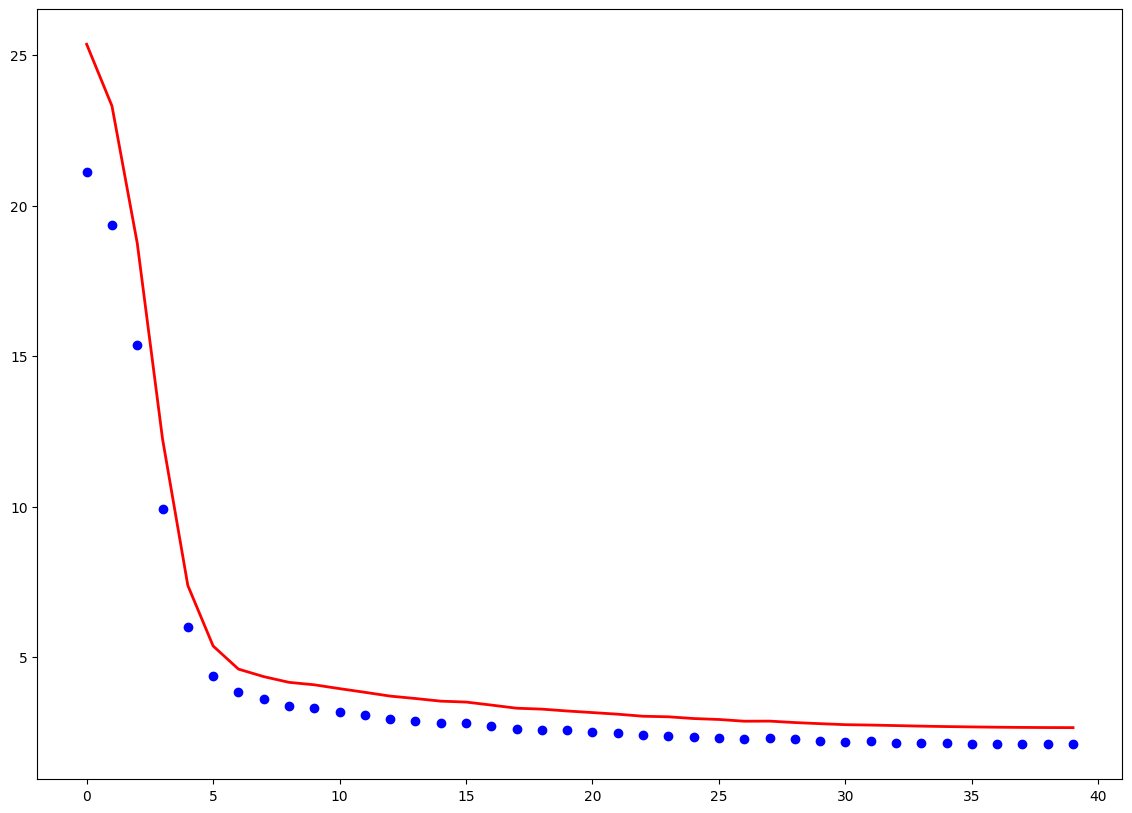

In [24]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MAE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["RMSE"], '-r', linewidth=2, label="Validation Loss")
# You can use metrics["SmoothL1Loss"] and metrics["SmoothL1Loss_val"] too.

### Evaluacion de Metricas

In [25]:
future = model.make_future_dataframe(df_raw_daily, periods=100, n_historic_predictions=len(df_raw_daily)) 
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.687% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.687% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 47it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


### Graficar las prediccion

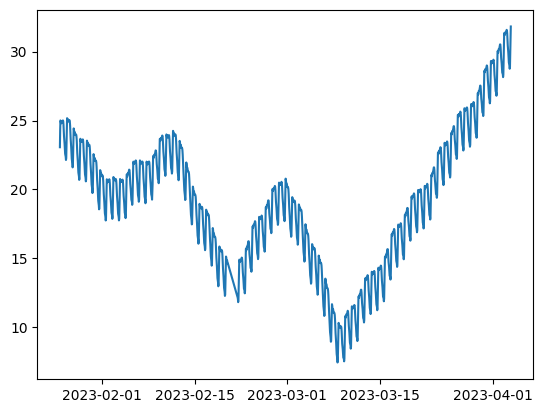

In [26]:
plt.plot(forecast.ds,forecast.yhat1)

### Tabla de Resultados

In [27]:
forecast

,ds,y,yhat1,trend,season_weekly,season_daily
0,2023-01-25 16:00:00,26.0,23.060110,24.494030,-0.544192,-0.889729
1,2023-01-25 17:00:00,31.0,24.318701,24.468609,-0.526208,0.376299
2,2023-01-25 18:00:00,31.0,25.005745,24.443188,-0.506051,1.068607
3,2023-01-25 19:00:00,31.0,24.963217,24.417768,-0.483776,1.029226
4,2023-01-25 20:00:00,31.0,24.786776,24.392345,-0.459454,0.853883
...,...,...,...,...,...,...
1593,2023-04-03 14:00:00,NaN,28.757771,30.516167,0.196490,-1.954888
1594,2023-04-03 15:00:00,NaN,28.894865,30.551487,0.172140,-1.828764
1595,2023-04-03 16:00:00,NaN,29.844576,30.586807,0.147497,-0.889729
1596,2023-04-03 17:00:00,NaN,31.121077,30.622139,0.122639,0.376299


### Parametros de la serie temporal

In [28]:
model.plot_parameters()

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~2h</i>',
              'type': 'scatter',
              'uid': '73a7f66f-1a64-4b45-98b8-7d66b239e4cf',
              'x': array([datetime.datetime(2023, 1, 25, 16, 0),
                          datetime.datetime(2023, 1, 25, 17, 0),
                          datetime.datetime(2023, 1, 25, 18, 0), ...,
                          datetime.datetime(2023, 3, 30, 10, 0),
                          datetime.datetime(2023, 3, 30, 12, 0),
                          datetime.datetime(2023, 3, 30, 14, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([24.49403006, 24.46860911, 24.44318816, ..., 26.98378478, 27.05443236,
                          27.12507993]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              

## 4. Codigo para predecir usando la Red Neuronal

In [102]:
# debe leer el dataset de la serie temporal
df =pd.read_csv('serie_temp.csv')

model = NeuralProphet(
    growth="linear",             # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None,           # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,                # Dimension of hidden layers of AR-Net    
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",             # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
    
)
model.fit(df,  freq="H")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (47) is too small than the required number for the learning rate finder (230). The results might not be optimal.


Finding best initial lr:   0%|          | 0/230 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,16.213276,20.503649,0.265838,0.0,0
1,14.931300,18.916567,0.232059,0.0,1
2,12.054903,15.130404,0.158854,0.0,2
3,7.945226,9.862055,0.072007,0.0,3
4,5.005785,6.221514,0.028172,0.0,4
5,4.296689,5.229673,0.019328,0.0,5
6,4.069925,4.908324,0.016534,0.0,6
7,3.837881,4.600304,0.014331,0.0,7
8,3.582603,4.348154,0.012715,0.0,8
9,3.465225,4.241737,0.011867,0.0,9


### Funcion para predecir el angulo


In [130]:
# Funcion para predecir el angulo
def pred_angulo_optimo(fecha_actual):
    now=fecha_actual
    last_date =  datetime.strptime(df.ds[len(df)-1],'%Y-%m-%d %H:%M:%S' )    
    periods   = round ((now-last_date).total_seconds()/3600)
    future = model.make_future_dataframe(df_raw_daily, periods= periods , n_historic_predictions=len(df)) 
    forecast = model.predict(future)
    ang_opt = forecast.yhat1[len(forecast.yhat1)-1]
    return round(ang_opt,1)   
    

In [129]:
# Aqui lee la fecha del sistema operativo
fecha_actual       =  datetime.now()

# Aqui usa la funcion de prediccion
ang_opt            = pred_angulo_optimo(datetime.now())

print('El angulo optimo es: ',ang_opt,'º' )

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.681% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.681% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 47it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


El angulo optimo es:  28.1 º
